# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

### **Objetivos**
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente open-ai gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


## **2. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [35]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
print ("Bins: ", bins[1])

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

Bins:  [0.         0.08333334 0.16666667 0.25       0.33333334 0.4166667
 0.5        0.5833334  0.6666667  0.75       0.8333334  0.9166667
 1.         1.0833334  1.1666667  1.25       1.3333334  1.4166667
 1.5       ]


## **3. Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [79]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # print(estado_siguiente)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender and estado_siguiente[6] and estado_siguiente[7]):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

### **4. Programando un agente que aprende**

A continuación implementamos el agente:

In [5]:
class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, initial_epsilon, final_epsilon, decay_factor) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.recompensa_maxima = -np.inf
        self.decay_factor = decay_factor
        self.threshold = 0
            
    def estado_discretizado_a_indice(self, estado_discretizado):
        return estado_discretizado[0] * 12800000 + estado_discretizado[1] * 640000 + estado_discretizado[2] * 32000 + \
           estado_discretizado[3] * 1600 + estado_discretizado[4] * 80 + estado_discretizado[5] * 4 + \
           estado_discretizado[6] * 2 + estado_discretizado[7]
           
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        estado_discretizado = discretize_state(estado, bins)
        row = self.estado_discretizado_a_indice(estado_discretizado)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.estado_discretizado_a_indice(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.estado_discretizado_a_indice(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.threshold: 
            self.epsilon = max(self.final_epsilon, self.epsilon*self.decay_factor)
            self.threshold += 1
        

#### **4.1 Diseño**

El agente es inicializado con una matriz Q de estados y acciones. Esta matriz almacena los valores de Q para cada par de estado y acción. Además, se lleva un registro de la cantidad de visitas (visits) que cada estado-acción ha tenido, lo que es utilizado para calcular el valor de alfa en el proceso de aprendizaje. 
Los parámetros de inicialización incluyen:

**gamma**: el factor de descuento, que pondera la importancia de las recompensas futuras.

**epsilon**: la probabilidad inicial de exploración, que va disminuyendo con el tiempo para promover la explotación del conocimiento adquirido.

**decay_factor**: el factor de decaimiento que decrementa el epsilon, y por lo tanto la tasa de exploración, con el tiempo.

Por cada iteración, el agente toma una decisión entre explorar o explotar, balanceando entre probar acciones nuevas y aprovechar las que han demostrado ser exitosas anteriormente. Si elige explorar, que esto sucede cuando toma un valor aleatorio entre 0 y 1 y este es menor a nuestro epsilon, selecciona una acción aleatoria entre las disponibles. Si elige explotar, selecciona la acción con el mayor valor Q asociado al estado actual.

### **5. Evaluación**

A continuación entrenaremos el agente con 100.000 episodios, para luego evaluar su desempeño con 1000 episodios de evaluación. Junto con el entrenamiento evaluaremos el decrecimiento del epsilon, la recompensa promedio cada 10.000 episodios, y la frecuencia de éxitos cada 10.000 episodios, con el fin de analizar la mejora del agente a lo largo del entrenamiento.

In [6]:
entorno = gym.make('LunarLander-v2').env
episodios = 100_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,initial_epsilon=1,final_epsilon=0.1,decay_factor=0.9)

exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
intervalos = 1000

for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon, '- Threshold:', agente.threshold)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 1000 iteraciones:  -466.5538809281087 - Epsilon: 1 - Threshold: 0
Episodio 1000 - Promedio de últimas 1000 iteraciones:  -157.27971022554377 - Epsilon: 0.22876792454961012 - Threshold: 14
Episodio 2000 - Promedio de últimas 1000 iteraciones:  -149.85157319325333 - Epsilon: 0.1 - Threshold: 35
Episodio 3000 - Promedio de últimas 1000 iteraciones:  -133.5359463367936 - Epsilon: 0.1 - Threshold: 46
Episodio 4000 - Promedio de últimas 1000 iteraciones:  -145.16407818236988 - Epsilon: 0.1 - Threshold: 54
Episodio 5000 - Promedio de últimas 1000 iteraciones:  -132.47316660662779 - Epsilon: 0.1 - Threshold: 60
Episodio 6000 - Promedio de últimas 1000 iteraciones:  -117.43688588280943 - Epsilon: 0.1 - Threshold: 72
Episodio 7000 - Promedio de últimas 1000 iteraciones:  -114.74764686218617 - Epsilon: 0.1 - Threshold: 94
Episodio 8000 - Promedio de últimas 1000 iteraciones:  -111.58434422554636 - Epsilon: 0.1 - Threshold: 107
Episodio 9000 - Promedio de últimas 1

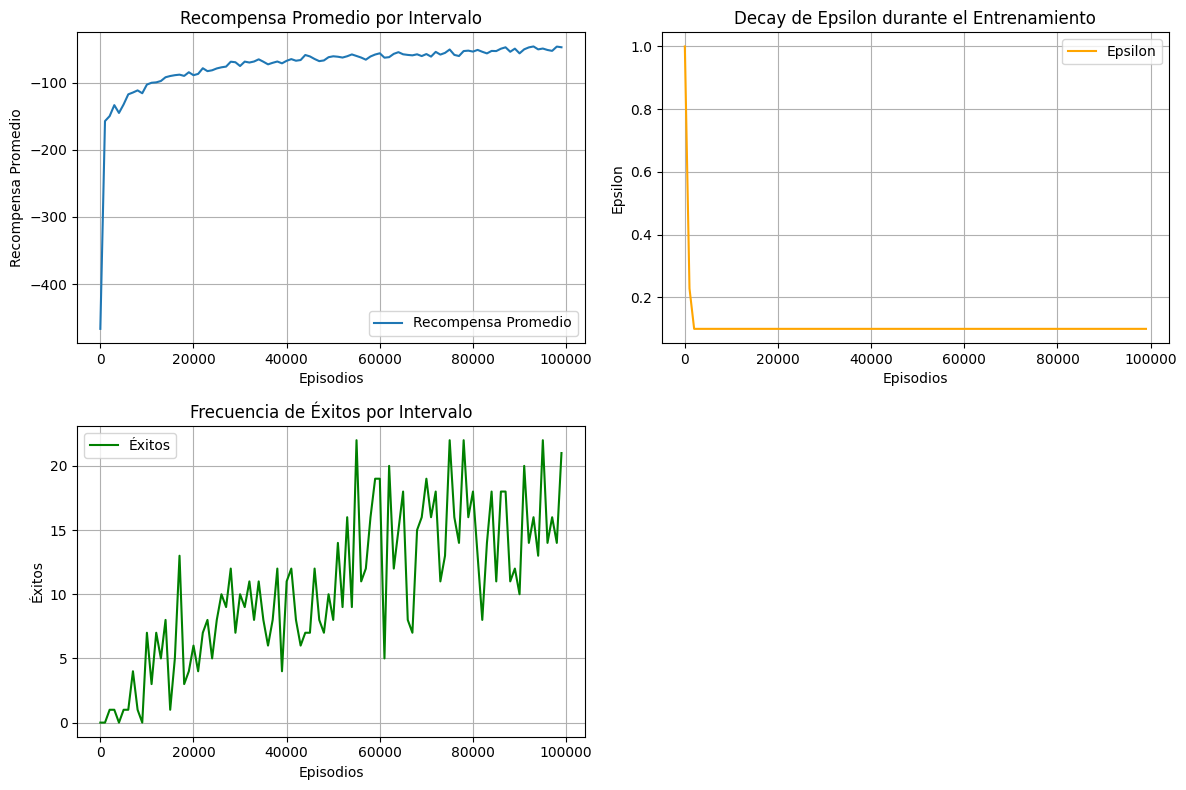

In [7]:

episodios_plot = range(0, episodios, intervalos)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))  # Cambiar el tamaño para acomodar mejor las tres gráficas

# Primera gráfica: Recompensas en función de episodios
plt.subplot(2, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(2, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Tercera gráfica: Éxitos en función de episodios
plt.subplot(2, 2, 3)
plt.plot(episodios_plot, exitos_intervalo_array, label='Éxitos', color='green')
plt.xlabel('Episodios')
plt.ylabel('Éxitos')
plt.title('Frecuencia de Éxitos por Intervalo')
plt.grid(True)
plt.legend()

# Ajustar automáticamente los espacios entre subplots
plt.tight_layout()

# Mostrar las gráficas
plt.show()


A través del gráfico de recompensas promedio cada 1000 episodios, observamos que inicialmente el agente recibe recompensas negativas bajas, lo que indica un desempeño deficiente en el aterrizaje (choques o aterrizajes ineficientes). Sin embargo, a medida que avanza el entrenamiento, el agente mejora gradualmente su desempeño, alcanzando un promedio de recompensa cercano a -50. Esto sugiere que el agente está aprendiendo a aterrizar de manera más segura y controlada con el tiempo. Sin embargo, la recompensa promedio sigue siendo negativa, por lo que no estamos teniendo una tasa de éxito ideal.

Luego, en el gráfico de decaimiento del epsilon, como era de esperarse, al ser el factor de decaimiento `decay_factor = 0.9`, el espilon disminuye al mínimo en las primeras 1000 iteraciones, dando mayor énfasis a la explotación sobre la exploración para el resto de episodios. Aún así, con el valor mínimo de epsilon establecido, por cada iteración se mantendrá un 10% de probabilidad de exploración, permitiendo que esto aún ocurra a lo largo del entrenamiento.

Por último, es observable que existe una tendencia a la mejora en la frecuencia de éxitos del agente, indicando que efectivamente está aprendiendo y obteniendo aterrizajes exitosos

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
    * Definir los estados (filas) de la matriz Q que cumplan con las condiciones planteadas (caida libre sin rotación, hovering, quieto en el piso)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [81]:
#ejecutar_episodio(agente, aprender=False, render=True, max_iteraciones=500)
#print()
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
        print('it', i, ' Exito: ',recompensa)
    recompensa_episodios += [recompensa]
    
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


it 43  Exito:  256.57170255327566
it 68  Exito:  213.56687584660352
it 100  Exito:  252.35136238742615
it 153  Exito:  227.8762058544375
it 191  Exito:  225.2521046005069
it 212  Exito:  212.54511109546877
it 269  Exito:  226.1659379317083
it 281  Exito:  213.76950224156258
it 298  Exito:  233.49466910854898
it 306  Exito:  224.41536226008097
it 342  Exito:  213.99887447725314
it 415  Exito:  251.9761384952717
it 443  Exito:  236.2498523054158
it 458  Exito:  207.5090170272745
it 468  Exito:  259.9057884037147
it 472  Exito:  221.809969134666
it 506  Exito:  236.63633823417044
it 510  Exito:  228.8856426838977
it 520  Exito:  243.39181164943852
it 529  Exito:  263.5049991916203
it 539  Exito:  243.63521366442123
it 559  Exito:  211.87255243763292
it 571  Exito:  238.912356983942
it 574  Exito:  200.1646379829296
it 655  Exito:  266.56606922452534
it 658  Exito:  244.1530406390435
it 718  Exito:  275.07451106395325
it 733  Exito:  288.859863616405
it 848  Exito:  245.41305203233816
it 8

#### **5.1 Cortes de matriz Q**

La función `state_examples` tiene como objetivo realizar un corte en la matriz Q, extrayendo subconjuntos de valores correspondientes a diferentes combinaciones de estados discretizados que representan situaciones específicas en el entorno del agente. Este corte permite analizar cómo se comporta el agente en esos estados particulares y cómo varían los valores Q para cada acción disponible, o sea, cómo el agente evalúa las acciones en función de la situación en la que se encuentra.

La función recibe varios parámetros que definen los rangos de las características del estado del agente, tales como:

- **min_x**, **max_x**, **min_y**, **max_y**: Definen los rangos de la posición en el espacio (coordenadas X e Y).
- **delta_x_vel**, **delta_y_vel**: Controlan el rango de velocidad horizontal y vertical.
- **delta_theta**, **delta_theta_vel**: Definen el rango de los ángulos de rotación y velocidad angular.
- **pie_izq_en_contacto**, **pie_der_en_contacto**: Indican si los pies izquierdo o derecho del agente están en contacto con el suelo.

Dada la división en 20 bins de cada dimensión, cada parámetro tendrá como valor posible un número entero entre 0 y 19. Para los parámetros describiendo coordenadas X e Y por ejemplo, observamos que el agente suele tomar como posición inicial **x=9 o x=10** e **y=11**. 

Dentro de la función, se generan múltiples combinaciones de estos parámetros, que se utilizan para obtener el índice correspondiente en la matriz Q. Estos índices se calculan con la función `agente.estado_discretizado_a_indice`, detallada previamente en el informe.

In [44]:
def state_examples(min_x, max_x, min_y, max_y, delta_x_vel, delta_y_vel, delta_theta, delta_theta_vel_izq, delta_theta_vel_der, pie_izq_en_contacto, pie_der_en_contacto):
    Rows = []
    for x in range(min_x,max_x):
        for y in range(min_y,max_y):
            for x_vel in range(9-delta_x_vel,11+delta_x_vel):
                for y_vel in range(9-delta_y_vel,11+delta_y_vel):
                    for theta in range(9-delta_theta,11+delta_theta):
                        for theta_vel in range(9-delta_theta_vel_der,11+delta_theta_vel_izq):
                            index = (int) (agente.estado_discretizado_a_indice([x,y,x_vel,y_vel,theta,theta_vel,pie_izq_en_contacto,pie_der_en_contacto]))
                            Rows = np.append(Rows, index)
    mRows = np.zeros(((int) (len(Rows)),4))
    for i in range(len(Rows)):
        mRows[i] = agente.Q[(int) (Rows[i])]
    mRows = mRows[np.any(mRows != 0, axis=1)]
    return mRows

In [70]:

# En el piso
print('En el piso')
floor = state_examples(min_x=0, max_x=20, min_y=0, max_y=9, delta_x_vel=1, delta_y_vel=0, delta_theta=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=1, pie_der_en_contacto=1)
print(len(floor))
print(np.mean(floor,0))

# Cayendo
print('Cayendo')
falling = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=3, delta_theta=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling))
print(np.mean(falling, 0))

# Hovering
print('Hovering')
hovering = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=1, delta_theta=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(hovering))
print(np.mean(hovering, 0))

# Aterrizando suavemente
print('Aterrizando suavemente')
landing_soft = state_examples(min_x=8, max_x=12, min_y=0, max_y=4, delta_x_vel=0, delta_y_vel=0, delta_theta=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(landing_soft))
print(np.mean(landing_soft, 0))

# Girando hacia la izquierda en el aire
print('Girando hacia la izquierda en el aire')
falling_spinning = state_examples(min_x=4, max_x=16, min_y=4, max_y=12, delta_x_vel=1, delta_y_vel=1, delta_theta=1, delta_theta_vel_izq=6, delta_theta_vel_der=-2, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling_spinning))
print(np.mean(falling_spinning, 0))



En el piso
598
[-7.34964833 -6.70470038 -5.56837752 -4.55177444]
Cayendo
924
[6.92723732 6.52435921 8.40391337 6.88981644]
Hovering
802
[7.70262631 7.3013828  9.05236509 7.70839297]
Aterrizando suavemente
253
[11.09620189 10.41525187 11.41163463 10.66807034]
Girando hacia la izquierda en el aire
1670
[1.9781594  1.97384803 4.2944657  2.33783123]
